## 비-연결 데이터 학습을 GNN으로 성능 향상하기

이번엔 저번에 완성을 못 하고 미뤄두었던: 

**MLP로는 학습이 잘 되지 않는 비-연결 데이터에 연결 구조를 부여해 GNN으로 성능을 향상시킬 수 있을까?**

가 궁금하여 한 번 간단히 해 보았습니다. 즉, GNN은 MLP와 다르게, 선형변환을 전 연결된 이웃 노드를 통해 feature 정보를 합쳐 주는 aggregation을 하여 주는데, 이것을 training set에 적용하여 GNN으로 학습을 시키면 성능향상이 될까? 라는 주제입니다.

먼저, 기존에 짜 두었던 MLP가 배우지 못하는 데이터셋을 만드는 루틴과 학습용 루틴을 그대로 가져오겠습니다.

In [33]:
import torch as t
import torch.nn.functional as F
import torch_geometric.nn as tgnn

from math import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
###################### DATAFRAME CLASS #######################

class dataframe:
  def __init__(self, data_tensor,data_class, trm,vm,tm, edges=None):
    
    self.num_features = data_tensor.shape[1]
    self.num_classes = int(max(data_class).item()+1)
    self.x = data_tensor
    self.num_nodes = data_tensor.shape[0]
    self.y = data_class
    self.train_mask = trm; self.val_mask = vm; self.test_mask = tm
    
    self.edge_index = edges
    if edges == None:
      self.num_edges = [None]
    else:
      self.num_edges = edges.shape[0]

In [3]:
################ CLASS OF FEED-FORWARD NEURAL NETS ################

class FFNN(t.nn.Module):
  def __init__(self, layers, activations, hidden_channels, data, 
               layer_options=False, fw_options=False, dropouts=False):
    super(FFNN,self).__init__()
    t.manual_seed(1)
    
    self.data = data
    self.activations = activations
    self.fw_options = fw_options
    self.dropouts = dropouts
    self.num_layers = len(layers)
    
    if layer_options == False:
      self.layer_options = [[] for i in range(self.num_layers)]
    if fw_options == False:
      self.fw_options = [[] for i in range(self.num_layers)]
      
    self.channels = hidden_channels
    self.channels.insert(0,self.data.num_features); 
    self.channels.append(self.data.num_classes)
    
    self.layers = [ ]
    for i in range(0,self.num_layers):
      args = [self.channels[i],self.channels[i+1]]; args.extend(self.layer_options[i])
      self.layers.append( layers[i]( *args ) )
    self.layers = t.nn.ModuleList(self.layers)
    
  def forward(self, x):
    for i in range(0,self.num_layers):
      args = [x]; args.extend(self.fw_options[i])
      x = self.activations[i]( self.layers[i]( *args ))
      if self.dropouts is not False:
        x = F.dropout(x, p=self.dropouts[i], training=self.training)
      else:
        pass
    return x

In [4]:
################ LEARNING & TESTING ROUTINE #################

class learn:
  def __init__(self, model, optimizer, criterion, epochs, data):
    
    self.data = data
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = t.arange(1,epochs+1)
    loss_vec = t.zeros((3,epochs)); acc_vec = t.zeros((3,epochs))
    
    for epoch in range(0,epochs):
      loss_vec[:,epoch], self.out = self.train_onestep()
      acc_vec[:,epoch] = self.get_accuracy(self.out)
  
    print("\n############################## LEARNING FINISHED! ##################################\n")
    
    self.train_loss = loss_vec[0,:]; self.train_acc = acc_vec[0,:]
    self.val_loss = loss_vec[1,:]; self.val_acc = acc_vec[1,:]
    self.test_loss = loss_vec[2,:]; self.test_acc = acc_vec[2,:]
    
    print(f'Test Accuracy: {self.test_acc[-1]:.4f}')
    
  def train_onestep(self):
    
    self.model.train()
    self.optimizer.zero_grad()
    out = self.model.forward(self.data.x)
    
    train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
    val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
    test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
    train_loss.backward() 
    self.optimizer.step()  
    
    return t.tensor([train_loss, val_loss, test_loss]), out
  
  def get_accuracy(self,out):
    
    self.model.eval()
    pred = out.argmax(dim=1) 
    
    train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
    val_correct = pred[self.data.val_mask] == self.data.y[self.data.val_mask]
    test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]
    
    train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
    val_acc = int(val_correct.sum()) / int(self.data.val_mask.sum())
    test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
    
    return t.tensor([train_acc, val_acc, test_acc])

In [5]:
############### VISUALIZING ROUTINE ################

def visualize(result, progress_plot=True, TSNE_plot=False):

  if progress_plot is True:
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    fig.suptitle("Learning Result", fontsize = 15)
    
    loss1, = ax[0].plot( result.epochs, result.train_loss, color='b', linewidth=2 , label = "Train set")
    loss2, = ax[0].plot( result.epochs, result.val_loss, color='g', linewidth=2 , label = "Validation set")
    loss3, = ax[0].plot( result.epochs, result.test_loss, color='r', linewidth=2, label = "Test set" )
    ax[0].legend(handles = [loss1, loss2, loss3])
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Loss")

    acc1, = ax[1].plot( result.epochs, result.train_acc, color='b', linewidth=2, label = "Train set")
    acc2, = ax[1].plot( result.epochs, result.val_acc, color='g', linewidth=2, label = "Validation set" )
    acc3, = ax[1].plot( result.epochs, result.test_acc, color='r', linewidth=2, label = "Test set" )
    ax[1].legend(handles = [loss1, loss2, loss3])
    ax[1].set_xlabel("Epochs")
    ax[1].set_title("Accuracy")
    plt.show()
  else:
    pass
  
  if TSNE_plot is True:
    z = TSNE(n_components=2).fit_transform(result.out.detach().cpu().numpy())
    fig,ax = plt.subplots()
    fig.set_size_inches(7,7)
    ax.set_title('2D projection of model output',fontsize=12)
    ax.scatter(z[:,0], z[:,1], s=70, c=result.data.y, cmap="Set2")
    plt.show()
  else:
    pass

아래 루틴은 MLP가 잘 학습하지 못하는 데이터를 만들어 줍니다.

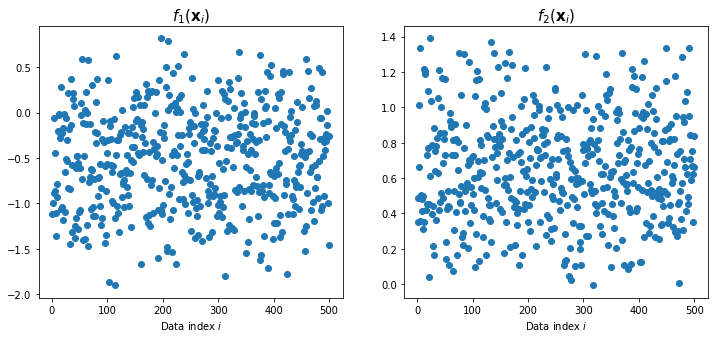

Class 0: 115 nodes
Class 1: 126 nodes
Class 2: 110 nodes
Class 3: 149 nodes
Training set: 201 nodes
Validation set: 142 nodes
Testing set: 157 nodes


In [6]:
################# DATA POINT GENERATION ##################

t.manual_seed(3)
data_dim = 4
data_num = 500
data_tensor = t.rand((data_num,data_dim))

coeffs = t.randn(2,4)  # AUXILLIARY FUNCTION FOR ASSIGNING DATA CLASS
def f(x,y,z,w):        
  val1 = t.dot(coeffs[0,:], t.tensor([sin(x),cos(y),asin(z),acos(w)]))
  val2 = t.dot(coeffs[1,:], t.tensor([exp(x),exp(y),cosh(z),sinh(w)]))
  return val1, val2

y1 = t.zeros(data_num); y2 = t.zeros(data_num) 

for i in range(data_num):
  y1[i], y2[i] = f(*data_tensor[i,:])
  
fig,axes = plt.subplots(1,2)
x = t.arange(1,data_num+1)
axes[0].scatter(x,y1); axes[1].scatter(x,y2)
axes[0].set_title("$f_1(\mathbf{x}_i)$", fontsize=15); axes[1].set_title("$f_2(\mathbf{x}_i)$", fontsize=15)
axes[0].set_xlabel("Data index $i$"); axes[1].set_xlabel("Data index $i$")
fig.set_size_inches(12,5)
plt.show(fig)

############### GENERATING DATA CLASSES ################

fact1 = y1 < -0.5; fact2 = y2 < 0.6      
data_class = t.zeros(data_num,dtype=t.uint8)  
#!!! CLASS TAGS MUST BE AN INTEGER. If not, torch's loss function returns error.
for i in range(0,data_num):
  if (fact1[i] == True) and (fact2[i] == True):
    data_class[i] = 0
  elif (fact1[i] == True) and (fact2[i] == False):
    data_class[i] = 1
  elif (fact1[i] == False) and (fact2[i] == True):
    data_class[i] = 2
  else:
    data_class[i] = 3
    
print(f"Class 0: {sum(data_class == 0)} nodes")
print(f"Class 1: {sum(data_class == 1)} nodes")
print(f"Class 2: {sum(data_class == 2)} nodes")
print(f"Class 3: {sum(data_class == 3)} nodes")

######### MASKING TRAINING, VALIDATING, AND TESTING NODES #########

randvec = t.rand(data_num)    
train_mask = randvec < 0.4
test_mask = randvec > 0.7
val_mask = t.zeros(data_num, dtype=t.bool)
for i in range(data_num):
  if train_mask[i] == False and test_mask[i] == False:
    val_mask[i] = True
  else:
    val_mask[i] = False
    
print(f"Training set: {sum(train_mask)} nodes")
print(f"Validation set: {sum(val_mask)} nodes")
print(f"Testing set: {sum(test_mask)} nodes")

data_tensor = t.remainder(data_tensor,0.5)
my_data = dataframe( data_tensor,data_class,train_mask,val_mask,test_mask)

위에 보시는 바와 같이, 저번 포스팅에서 만든 데이터셋 'my_data'는 총 500개의 데이터 포인트가 타겟 0 ~ 3까지 4개의 클래스로 분류되어 있고,
201개의 Training data, 142개의 Validating data, 157개의 Testing data로 나누어져 있습니다.

간단한 2-레이어 MLP 모델로 학습을 해 보면,

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4331


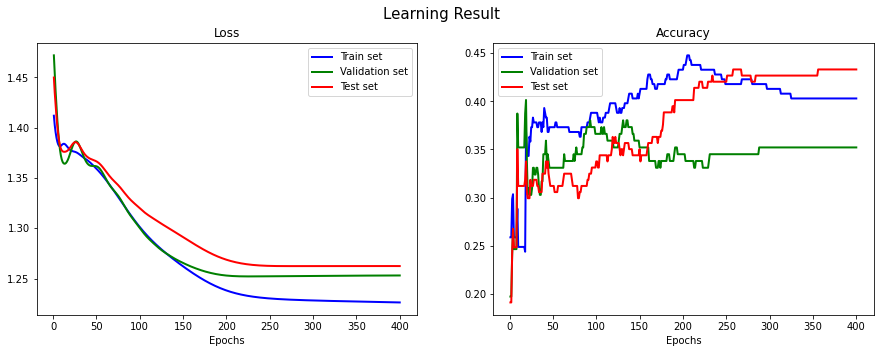

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


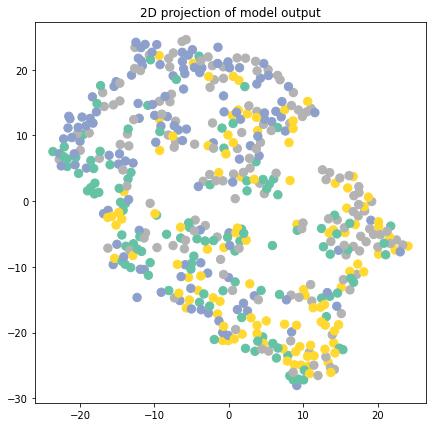

In [17]:
data = my_data
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ t.sigmoid, t.nn.Identity() ],
            hidden_channels = [ 8 ],
            data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 400,
                data = data)

visualize(result,TSNE_plot=True)

학습이 잘 되지 않는 것을 볼 수 있습니다.

**이제, Training set에 대해 연결구조를 임의로 부여해 보겠습니다.** 사실 저번에는 GNN에 넣기 위해 그래프 객체를 따로 만들어줘야 하는 줄 알고 착각을 하였는데, 연결 정보만 알려주는 $2\times N$ 모양의 edge_index 텐서만 만들어 주고 GNN 레이어에 넣으면 되는 거라, 큰 전처리 없이 간단히 edge_index 텐서만 만들어서 해보겠습니다. 

아래 루틴은 같은 클래스에 속한 training data node간에 $p$의 확률로 edge를 부여하는 함수입니다. 

In [37]:
############# GRANTING CUSTOM GRAPH STRUCTURE TO TRAINING DATASET ##############

def generate_edges(data,p):
  
  edge_index = t.tensor([[],[]])
  
  for i in range(sum(data.train_mask)):
    for j in range(i+1,sum(data.train_mask)):
      if data.y[i] == data.y[j]:
        if t.rand(1) <= p:
          edge_index = t.cat( (edge_index,t.tensor([[i],[j]])) ,dim=1)
          
  setattr(data,"edge_index",edge_index.to(dtype=t.long))

이제 적당한 확률($p=0.3$을 사용했습니다)로 edge를 부여하고, GNN으로 학습을 해 보겠습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): GCNConv(4, 8)
    (1): GCNConv(8, 4)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.6115


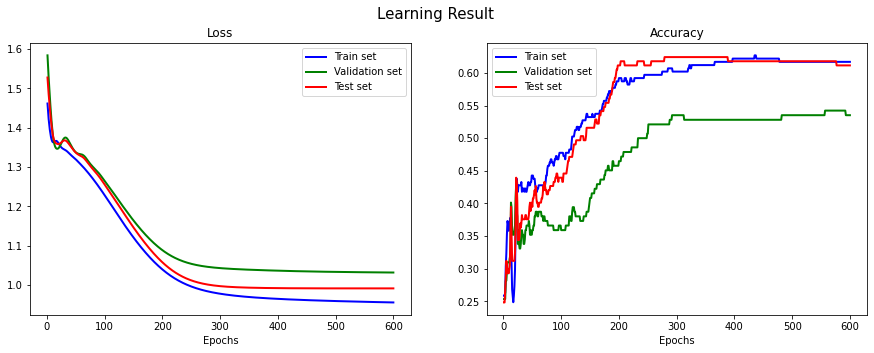

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


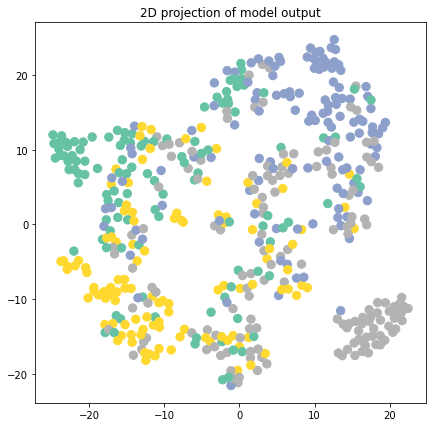

In [38]:
generate_edges(my_data,p=0.3)

data = my_data
model = FFNN( layers = [tgnn.GCNConv, tgnn.GCNConv],
              activations = [ t.sigmoid, t.nn.Identity() ],
              fw_options = [ [data.edge_index], [data.edge_index] ],
              hidden_channels = [ 8 ],
              data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 600,
                data = data)

visualize(result,TSNE_plot=True)

정확도가 40퍼센트 근처에서 60퍼센트까지 소폭(?) 상승한 것을 볼 수 있습니다.

여담으로, 연결 구조를 아예 부여하지 않고 ($p=0$) 학습하면 GNN이나 MLP나 매우 비슷함을 알 수 있습니다(구조 상 그럴 수 밖에 없습니다).

Current model: 
FFNN(
  (layers): ModuleList(
    (0): GCNConv(4, 8)
    (1): GCNConv(8, 4)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4331


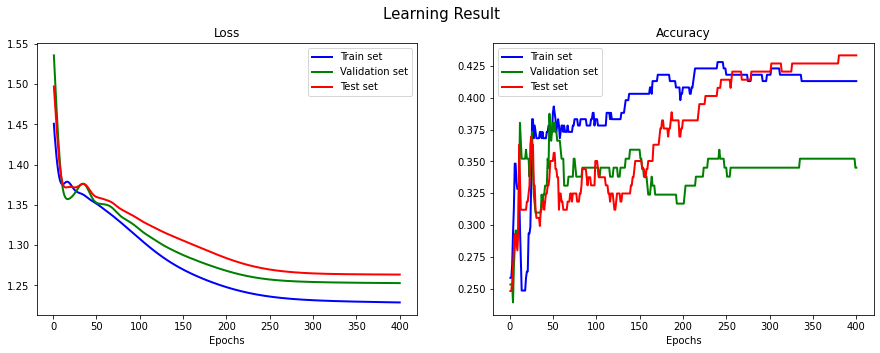

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


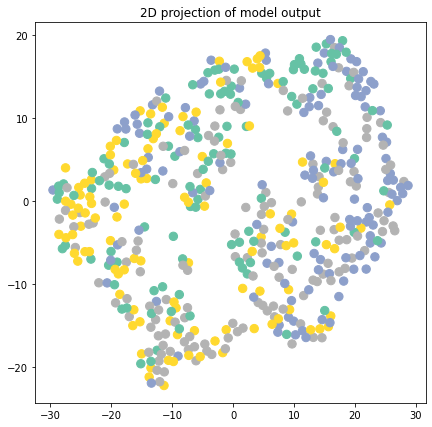

In [39]:
generate_edges(my_data,p=0)

data = my_data
model = FFNN( layers = [tgnn.GCNConv, tgnn.GCNConv],
              activations = [ t.sigmoid, t.nn.Identity() ],
              fw_options = [ [data.edge_index], [data.edge_index] ],
              hidden_channels = [ 8 ],
              data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 400,
                data = data)

visualize(result,TSNE_plot=True)

Training set 연결 확률 별로 학습한 GNN의 최종 정확도를 한 번 구해보겠습니다.

In [28]:
p_vec = t.arange(0,1.001,0.01)
acc_vec = t.zeros(p_vec.shape[0])

for i in range(p_vec.shape[0]):
  print(f"p: {p_vec[i]}")
  generate_edges(my_data,p=p_vec[i])

  data = my_data
  model = FFNN( layers = [tgnn.GCNConv, tgnn.GCNConv],
              activations = [ t.sigmoid, t.nn.Identity() ],
              fw_options = [ [data.edge_index], [data.edge_index] ],
              hidden_channels = [ 8 ],
              data = data)

  result = learn( model = model, 
                    optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                    criterion = t.nn.CrossEntropyLoss(), 
                    epochs = 600,
                    data = data)
  
  acc_vec[i] = result.test_acc[-1]

p: 0.0

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4268
p: 0.009999999776482582

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4204
p: 0.019999999552965164

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4268
p: 0.029999999329447746

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4522
p: 0.03999999910593033

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4777
p: 0.05000000074505806

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4777
p: 0.05999999865889549

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4904
p: 0.07000000029802322

############################## LEARNING FINISHED! ###############

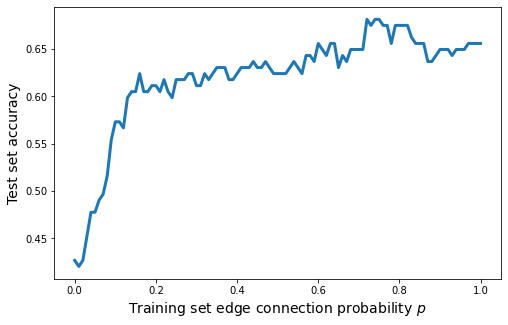

In [32]:
fig,ax = plt.subplots()
fig.set_size_inches(8,5)
ax.set_xlabel("Training set edge connection probability $p$",fontsize=14)
ax.set_ylabel("Test set accuracy",fontsize=14)
ax.plot(p_vec,acc_vec,lw=3)
plt.show(fig)

연결 확률이 높으면 높을 수록 어느 정도 MLP에 비해 성능 향상이 이루어지는 것을 볼 수 있었습니다.

번외로, 아예 test 데이터까지 포함하여 전체 데이터셋 깡그리 class 별로 묶어봤습니다(*물론, 이러면 GNN특성상 학습 과정에 자연히 test 데이터의 정답을 같이 넣어 알려주는 셈이 되므로 당연히 의미는 없습니다*).

Current model: 
FFNN(
  (layers): ModuleList(
    (0): GCNConv(4, 8)
    (1): GCNConv(8, 4)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.9936


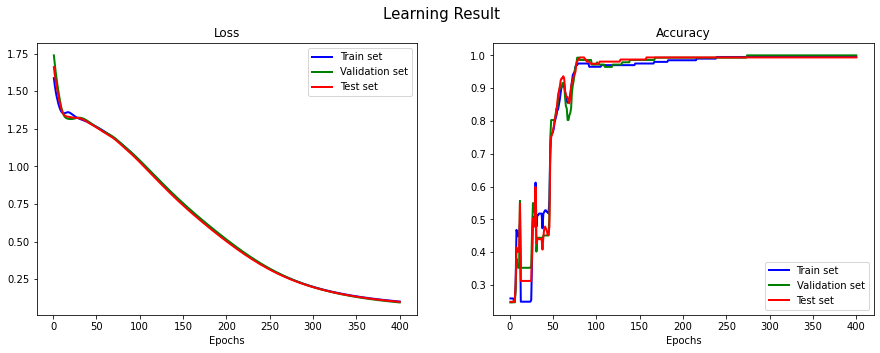

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


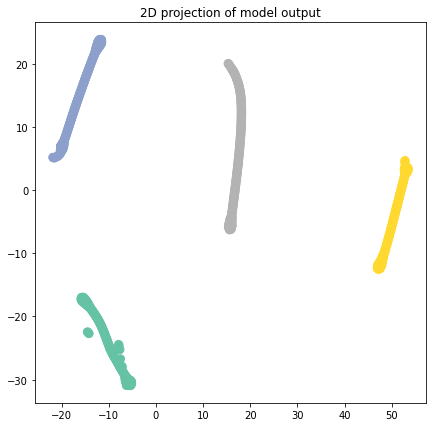

In [41]:
def generate_edges(data,p):
  
  edge_index = t.tensor([[],[]])
  
  for i in range(data.x.shape[0]):
    for j in range(i+1,data.x.shape[0]):
      if data.y[i] == data.y[j]:
        if t.rand(1) <= p:
          edge_index = t.cat( (edge_index,t.tensor([[i],[j]])) ,dim=1)
          
  setattr(data,"edge_index",edge_index.to(dtype=t.long))
  
generate_edges(my_data,p=1)

data = my_data
model = FFNN( layers = [tgnn.GCNConv, tgnn.GCNConv],
              activations = [ t.sigmoid, t.nn.Identity() ],
              fw_options = [ [data.edge_index], [data.edge_index] ],
              hidden_channels = [ 8 ],
              data = data); print(f"Current model: \n{model}")

result = learn( model = model, 
                optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                criterion = t.nn.CrossEntropyLoss(), 
                epochs = 400,
                data = data)

visualize(result,TSNE_plot=True)

역시 과적합 따위는 없는 어마어마한 정답률과 손실률을 보입니다.

## 결론

* MLP가 잘 학습하지 못하는 비-연결 데이터의 training set에 클래스 별로 edge 연결을 부여하면, GNN으로 학습했을 떄 어느 정도의 성능 향상은 기대할 수 있는 것 같습니다.